In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy import stats
xr.set_options(keep_attrs=True)
import sys
sys.path.insert(1, '/glade/u/home/lettier/analysis/analysis_temp-asym/pub/')
import asym_funcs as af
import cartopy.crs as ccrs
import importlib
importlib.reload(af)

<module 'asym_funcs' from '/glade/u/home/lettier/analysis/analysis_temp-asym/pub/asym_funcs.py'>

In [2]:
ds = xr.open_dataset('../obsdata/daily_TREFHT_ERA5_1979-2018mean_zonalvariations.nc')

In [3]:
ds = ds.where(abs(ds.lat)>20)
ds_f = af.xr_fourier_decomp (ds.dayofyear/len(ds.dayofyear), ds, 4, 'dayofyear')
a, t1 ,t2  =  af.asym_xr(ds_f,'dayofyear')
obds = -a.rename({'VAR_2T':'T_delta'})

In [4]:
mydir = '../simplemodel/output/zonal/'
listds = []
for lon in np.arange(0.5,360.5,1):
    ods = xr.open_dataset(mydir+'ODEn800_CERES_SFC-SW-down_lon'+str(lon)+'.nc')
    ods = ods.set_coords('lon')
    listds.append(ods)
ods = xr.concat(listds,dim='lon')  
ods = ods.where(abs(ods.lat)>20)
ods = ods.interp(lat=obds.lat).interp(lon=obds.lon)

In [5]:
a, t1, t2 = af.asym_xr(ods.T,dim='time')
a = -a/1000.*365
t1 = t1/1000.*365
t2 = t2/1000.*365

In [6]:
def calc_delta_from_ode (datadir, fname):

    odeds = xr.open_dataset(datadir+fname)
    a, t1, t2 = af.asym_xr(odeds.T,dim='time')
    a = -a/1000.*365
    t1 = t1/1000.*365
    t2 = t2/1000.*365

    a = a.to_dataset(name='T_delta')
    t1 = t1.to_dataset(name='T_t1')
    t2 = t2.to_dataset(name='T_t2')
    ds = xr.merge([odeds, a, t1, t2])
    ds.attrs['desc'] = '20y climatology'
    ds.T_delta.attrs['units'] = 'd'
    ds.T_t1.attrs['units'] = 'd'
    ds.T_t2.attrs['units'] = 'd'
    ds = ds.where(abs(ds.lat)>20)
    
    return ds

In [7]:
stdds =  calc_delta_from_ode ('../simplemodel/output/', 'ODEn800_TOAinsolation.nc').interp(lat=obds.lat)
plot3 = stdds.T_delta.expand_dims(dim={'lon': obds.lon})

In [8]:
stdds =  calc_delta_from_ode ('../simplemodel/output/', 'ODEn800_CERES_SFC-SW-down.nc').interp(lat=obds.lat)
plots = stdds.T_delta.expand_dims(dim={'lon': obds.lon})

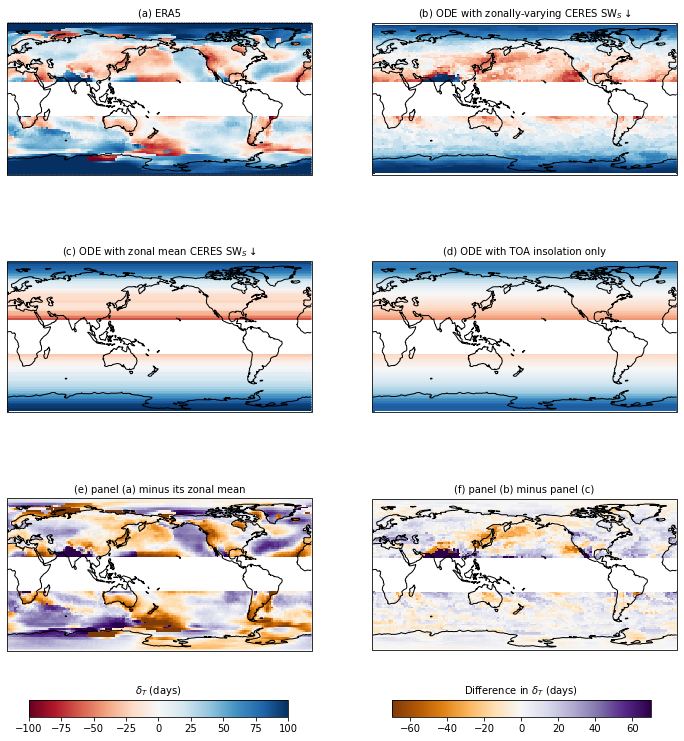

In [9]:
fig = plt.figure(figsize=(12,12))

ax = plt.subplot(3,2,1, projection = ccrs.PlateCarree(central_longitude=180))
ax.pcolormesh(obds.lon, obds.lat, obds.T_delta, transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap = plt.cm.RdBu)
ax.coastlines()
ax.set_title('(a) ERA5',fontsize=10)

ax = plt.subplot(3,2,2, projection = ccrs.PlateCarree(central_longitude=180))
ax.pcolormesh(ods.lon, ods.lat, a.T, transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap = plt.cm.RdBu)
ax.coastlines()
ax.set_title('(b) ODE with zonally-varying CERES SW$_{S}\downarrow$',fontsize=10)
 
ax = plt.subplot(3,2,3, projection = ccrs.PlateCarree(central_longitude=180))
CS1 = ax.pcolormesh(ods.lon, ods.lat, plots.T, transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap = plt.cm.RdBu)
ax.coastlines()
ax.set_title('(c) ODE with zonal mean CERES SW$_{S}\downarrow$',fontsize=10)

ax = plt.subplot(3,2,4, projection = ccrs.PlateCarree(central_longitude=180))
CS1 = ax.pcolormesh(ods.lon, ods.lat, plot3.T, transform=ccrs.PlateCarree(),vmin=-100,vmax=100,cmap = plt.cm.RdBu)
ax.coastlines()
ax.set_title('(d) ODE with TOA insolation only',fontsize=10)


ax = plt.subplot(3,2,5, projection = ccrs.PlateCarree(central_longitude=180))
ax.pcolormesh(obds.lon, obds.lat, obds.T_delta - obds.T_delta.mean(dim='lon'), transform=ccrs.PlateCarree(),vmin=-70,vmax=70,
              cmap = plt.cm.PuOr)
ax.coastlines()
ax.set_title('(e) panel (a) minus its zonal mean',fontsize=10)

ax = plt.subplot(3,2,6, projection = ccrs.PlateCarree(central_longitude=180))
CS2 = ax.pcolormesh(ods.lon, ods.lat, a.T - plots.T, transform=ccrs.PlateCarree(),vmin=-70,vmax=70,cmap = plt.cm.PuOr)
ax.coastlines()
ax.set_title('(f) panel (b) minus panel (c)',fontsize=10)

cbar_ax = fig.add_axes([0.15, 0.05, 0.3, 0.02]) #[left, bottom, width, height]
cbar = fig.colorbar(CS1, cax=cbar_ax,  orientation='horizontal')
cbar.ax.set_title('$\delta_T$ (days)',fontsize=10)
             
cbar_ax = fig.add_axes([0.57, 0.05, 0.3, 0.02]) #[left, bottom, width, height]
cbar = fig.colorbar(CS2, cax=cbar_ax,  orientation='horizontal')
cbar.ax.set_title('Difference in $\delta_T$ (days)',fontsize=10)

plt.tight_layout()



plt.subplots_adjust(bottom=0.1)

fig.savefig('../figs/figS8.pdf',bbox_inches='tight',dpi=300)
plt.show()
plt.close()          